In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

# **Statistical Analysis**

In [2]:
# Import useful libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from collections import defaultdict

import matplotlib as mpl
import seaborn as sns

sns.set(style ='white',font_scale=1.25)

%matplotlib inline

In [3]:
with open('../data/01-House-Price/wrangled_data.pkl','rb') as file:
    housing_orig, FEATURES = pickle.load(file)

In [4]:
housing = housing_orig.copy()
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleType,SaleCondition,SalePrice,log1p(SalePrice),log1p(GrLivArea),Lat,Lng,zipcode,median_household_income,median_home_value
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Missing,Reg,Lvl,AllPub,Inside,...,WD,Normal,208500,12.247699,7.444833,42.022197,-93.651510,50010.0,48189.0,165300.0
2,20,RL,80.0,9600,Pave,Missing,Reg,Lvl,AllPub,FR2,...,WD,Normal,181500,12.109016,7.141245,42.041304,-93.650302,50011.0,48189.0,165300.0
3,60,RL,68.0,11250,Pave,Missing,IR1,Lvl,AllPub,Inside,...,WD,Normal,223500,12.317171,7.488294,42.022197,-93.651510,50010.0,48189.0,165300.0
4,70,RL,60.0,9550,Pave,Missing,IR1,Lvl,AllPub,Corner,...,WD,Abnorml,140000,11.849405,7.448916,42.018614,-93.648898,50014.0,37661.0,212500.0
5,60,RL,84.0,14260,Pave,Missing,IR1,Lvl,AllPub,FR2,...,WD,Normal,250000,12.429220,7.695758,42.053510,-93.648636,50010.0,48189.0,165300.0


## Important features
* Numerical features:
    1. OverallQual
    2. GarageArea
    3. TotalBsmtSF
    4. GarageYrBlt
    5. 1stFlrSF
    6. BsmtFinSF1
    7. BsmtFullBath
    8. OverallCond
* Categorical features:
    9. SaleCondition
    10. Functional
    11. Neighborhood
    12. Exterior1st
    13. Condition1
    14. MSSubClass
    15. BsmtQual
    16. SaleType
    17. HeatingQC
    18. GarageType
    19. ExterQual
    20. RoofMatl
    21. Heating

In [5]:
impfeat = 'OverallCond SaleCondition Functional \
            Neighborhood Exterior1st Condition1 \
            BsmtFinSF1 BsmtFullBath OverallQual \
            GarageYrBlt MSSubClass 1stFlrSF GarageArea \
            BsmtQual TotalBsmtSF SaleType HeatingQC \
            GarageType ExterQual RoofMatl Heating'.split()

In [6]:
housing_num = housing[[feat for feat in impfeat if feat in FEATURES['num']]]

## Numerical Featurs: Correlations with Sale Price

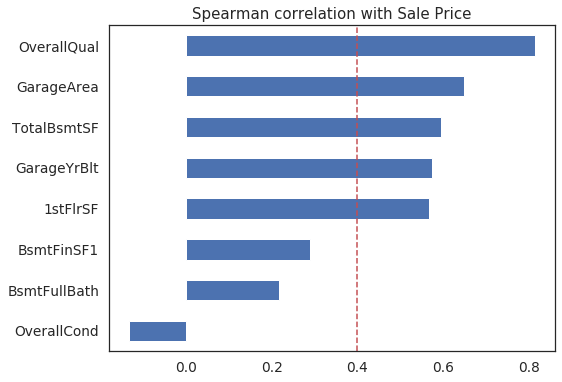

In [7]:
housing_num.corrwith(housing.SalePrice,method='spearman').sort_values(ascending=True).plot.barh(figsize=(8,6),title = 'Spearman correlation with Sale Price')
plt.axvline(x=0.4,linestyle='--',color='r')

__GarageArea, TotalBsmtSF, GarageYrBlt,__ and __1stFlrSF__ are highly correlated with the SalePrice.

## Numerical Features: correlations among features

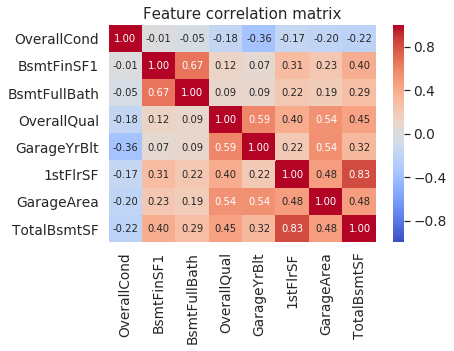

In [8]:
sns.heatmap(housing_num.corr(method='spearman'),
            vmax=1,vmin=-1,annot=True,cmap='coolwarm',fmt='.2f')
_=plt.title("Feature correlation matrix")

__TotalBsmtSF__ is highly correlated with __1stFlrSF__. 
There are also some moderately high correlated feature pairs.

## Numerical Features: Variance Inflation Factor (VIF)

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

df_for_VIF = housing_num.copy()
df_for_VIF = sm.add_constant(df_for_VIF)
VIF_df = pd.DataFrame()
VIF_df['Feature'] = df_for_VIF.columns
VIF_df['VIF'] = [variance_inflation_factor(df_for_VIF.values, i) for i in range(df_for_VIF.shape[1])]
VIF_df.drop(index=0,inplace=True)

/home/climbach/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Text(0.5, 1.0, 'Variance inflation factor (VIF)')

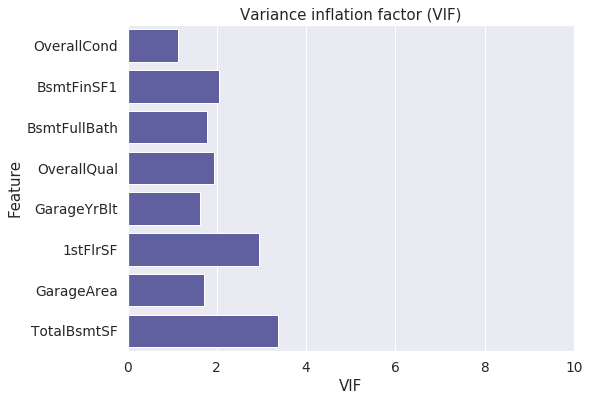

In [12]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.25)
sns.barplot(y='Feature',x='VIF',data=VIF_df,saturation=0.25,capsize=0.25,color='blue')
plt.xlim(0, 10)
plt.title('Variance inflation factor (VIF)')

VIF for most features look fine except for 1stFlrSF and TotalBsmtSF, with the latter being highest. Ideally VIFs should be 1, however values upto 2 are acceptable. For TotalBsmtSF is 3.36, which indicates that 70% of its variance is explained by a linear combination of remaining features. This will lead estimates that are unstable.

## Categorical Features: ANOVA

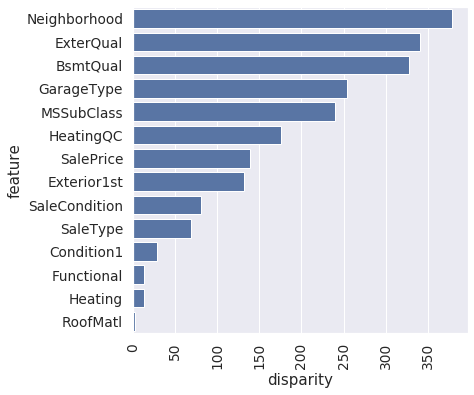

In [14]:
import scipy.stats as stats
housing_cat = housing[[feat for feat in impfeat if feat not in FEATURES['num']]]
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = frame.columns
    pvals = []
    for c in frame.columns:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.kruskal(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval').reset_index(drop=True)

a = anova(housing_cat.join(housing.SalePrice))
a['disparity'] = np.log(1./a['pval'].values)
plt.figure(figsize=(6,6))
sns.barplot(x='disparity',y='feature',data=a,color=sns.color_palette(n_colors=1)[0])
x=plt.xticks(rotation=90)

The above bar plot shows influence of each categorical feature on the sale price. Features with higher disparity have greater influence on the sale price.